In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import gc
import re
import string
import operator
from collections import defaultdict

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
!pip3 install tensorflow
!pip3 install tensorflow_hub latest
!pip3 install bert-tensorflow
!pip3 install wordcloud

In [4]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

from bert import tokenization
from wordcloud import STOPWORDS

In [5]:
df_train = pd.read_csv('train.csv')
df_train.shape

(7613, 5)

In [6]:
df_train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [7]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
df_train.keyword.unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [9]:
df_train.location.unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

In [10]:
df_train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [11]:
df_test = pd.read_csv('test.csv')
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [12]:
df_test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [13]:
print(f'Number of unique values in keyword = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {df_train["location"].nunique()} (Training) - {df_test["location"].nunique()} (Test)')

Number of unique values in keyword = 221 (Training) - 221 (Test)
Number of unique values in location = 3341 (Training) - 1602 (Test)


In [14]:
# This is different from df_train.groupby('keyword')['target'].mean()!

df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

df_train[df_train.target_mean.notnull()].head()

,id,keyword,location,text,target,target_mean
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,0.361111
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,0.361111
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,0.361111
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,0.361111
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,0.361111


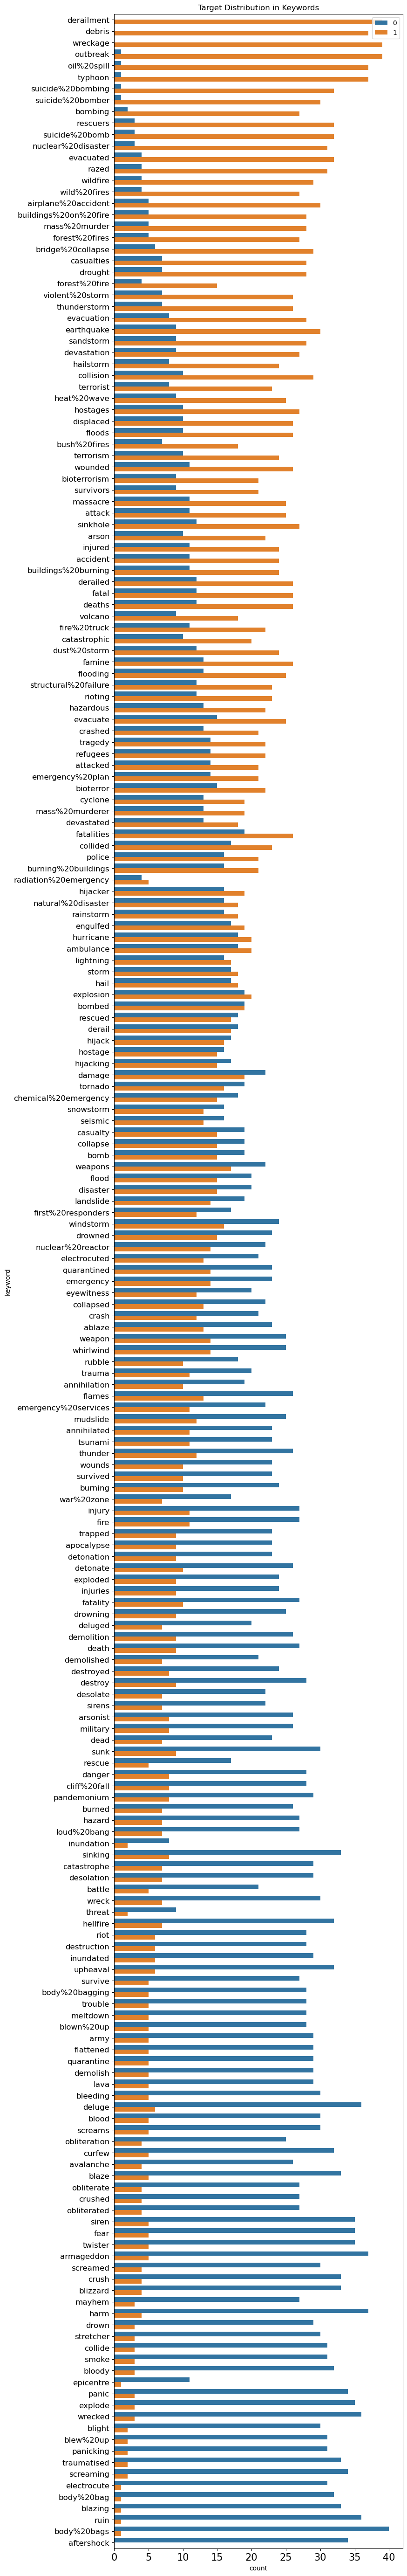

In [15]:
fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

In [16]:
df_keyword_p = df_train.groupby(['keyword','target'])['id'].count()\
               .reset_index().rename(columns={'id':'counts'})\
               .sort_values(['target','counts'],ascending=False)
df_keyword_p

,keyword,target,counts
138,derailment,1,39
304,outbreak,1,39
435,wreckage,1,39
123,debris,1,37
302,oil%20spill,1,37
408,typhoon,1,37
190,evacuated,1,32
330,rescuers,1,32
368,suicide%20bomb,1,32
372,suicide%20bombing,1,32


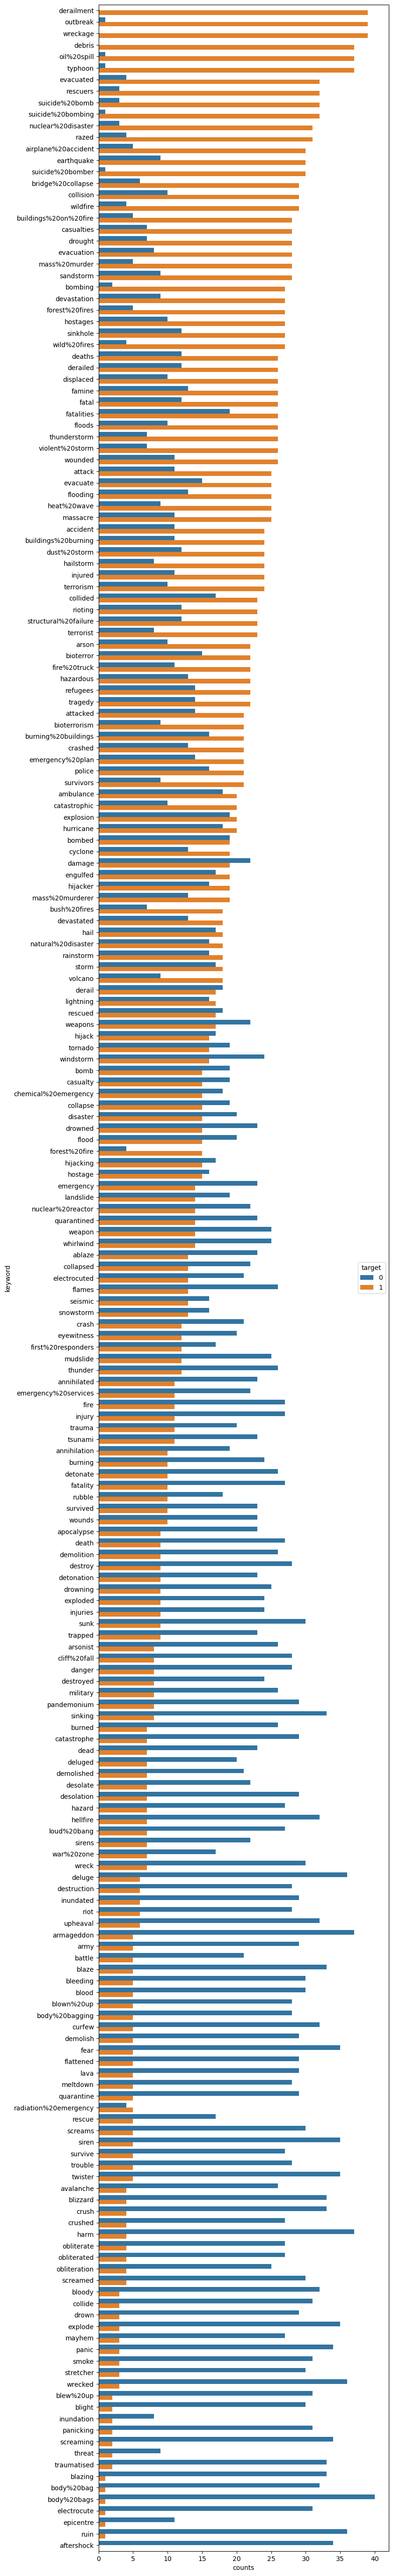

In [17]:
fig = plt.figure(figsize=(8, 72), dpi=100)
sns.barplot(x='counts',y='keyword',hue = 'target', data = df_keyword_p)
plt.show()

In [18]:
# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

In [19]:
df_train

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,13,6
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,7,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,20,11
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,8,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,15,7
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,11,11,2
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,20,17,9
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,8,8,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,19,19,5
